# Data Preprocessing and sentiment classification Script (With Evaluation Metrics)
This notebook preprocesses the Amazon reviews data for sentiment analysis with improved functional organization and evaluation metrics.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import nltk
from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
from transformers import pipeline

# Download required NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

## Text Cleaning and Sentiment Analysis Functions

Here we define separate functions for text cleaning and sentiment analysis.

In [3]:
import re
import pandas as pd # Ensure pandas is imported

def clean_text(text):

    # Handle NaN values - Return empty string for consistency
    if pd.isna(text):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove URLs - Replace with a space to avoid merging words
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove user mentions (@) - Replace with a space
    text = re.sub(r'@\w+', ' ', text)

    # Remove hashtags (#) - Replace with a space
    text = re.sub(r'#\w+', ' ', text)

    # Keep letters, numbers, whitespace, and basic useful punctuation (' . ! ?)
    # Remove characters NOT in this allowed set by replacing them with a space.
    # Allowed: a-z, 0-9, whitespace, apostrophe, period, exclamation, question mark
    text = re.sub(r"[^a-z0-9\s'.!?]", ' ', text) # Note: Already lowercased, so only need a-z

    # Remove multiple spaces introduced by replacements and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Sentiment pipeline

In [4]:

sentiment_pipeline = pipeline("sentiment-analysis",
                             model="cardiffnlp/twitter-roberta-base-sentiment",
                             device=0)  # Use GPU if available, set to -1 for CPU

def analyze_sentiment(cleaned_text):
    """
    Apply sentiment analysis using a pre-trained pipeline.

    Parameters:
        cleaned_text (str): The cleaned text to be analyzed.

    Returns:
        tuple: (sentiment_label, sentiment_score)
    """
    # Handle empty text
    if not cleaned_text or cleaned_text.isspace():
        return "NEUTRAL", 0.0

    # Apply the sentiment analysis pipeline to the cleaned text
    try:
        result = sentiment_pipeline(cleaned_text, truncation=True, max_length=512)[0]

        # Extract label and score from the result
        sentiment_label = result['label']
        sentiment_score = result['score']

        return sentiment_label, sentiment_score
    except Exception as e:
        print(f"Error processing text: {e}")
        return "NEUTRAL", 0.0

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
test_result = analyze_sentiment("This is a test sentence.")
print(test_result)
# Or directly use the pipeline
# print(sentiment_pipeline("This is another test."))

('LABEL_1', 0.5441432595252991)


In [6]:
def analyze_text_sentiment(new_text):

    # Clean the input text
    cleaned_text = clean_text(new_text)

    # Apply sentiment analysis
    return analyze_sentiment(cleaned_text)

In [7]:
def map_sentiment_labels(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    elif rating >= 4:
        return "Positive"

## Load and Explore Data

In [8]:
# Load the dataset
# Adjust the path as needed for your environment
file_path = '/content/drive/MyDrive/RoboRev/Dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
print(f"Loading dataset from {file_path}...")
df = pd.read_csv(file_path, encoding='latin1')
print(f"Dataset loaded with {len(df)} rows.")

# Display the first few rows of the DataFrame
df.head()

Loading dataset from /content/drive/MyDrive/RoboRev/Dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv...
Dataset loaded with 28332 rows.


,ï»¿id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [9]:
# Check column names
print(df.columns)

Index(['ï»¿id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')


## Apply Text Cleaning to the Dataset

In [10]:
# Apply the text cleaning function to the reviews
print("Cleaning text data...")
df['cleaned_text'] = df['reviews.text'].apply(clean_text)
print("Text cleaning completed.")

# Display a few examples of original and cleaned text
print("\nOriginal vs Cleaned Text Examples:")
for i in range(3):
    print(f"\nOriginal: {df['reviews.text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")

Cleaning text data...
Text cleaning completed.

Original vs Cleaned Text Examples:

Original: I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.
Cleaned: i order 3 of them and one of the item is bad quality. is missing backup spring so i have to put a pcs of aluminum to make the battery work.

Original: Bulk is always the less expensive way to go for products like these
Cleaned: bulk is always the less expensive way to go for products like these

Original: Well they are not Duracell but for the price i am happy.
Cleaned: well they are not duracell but for the price i am happy.


## Apply Sentiment Analysis to the Cleaned Text Column

In [11]:
# Apply sentiment analysis to the cleaned text column
print("Applying sentiment analysis.")
start_time = time.time()

# Process the cleaned text column with a progress bar
tqdm.pandas(desc="Processing")
results = df['cleaned_text'].progress_apply(lambda text: pd.Series(analyze_sentiment(text)))
results.columns = ['sentiment_label', 'sentiment_score']

# Create a new results dataframe with only the columns we need
results_df = pd.DataFrame({
    'reviews.text': df['reviews.text'],
    'cleaned_text': df['cleaned_text'],
    'name': df['name'],                # Add this line
    'categories': df['categories'],    # Add this line
    'sentiment_label': results['sentiment_label'],
    'sentiment_score': results['sentiment_score']
})

# Add the star rating if available
if 'reviews.rating' in df.columns:
    results_df['reviews.rating'] = df['reviews.rating']

    # Map ratings to sentiment categories for comparison
    results_df['rating_sentiment'] = df['reviews.rating'].apply(map_sentiment_labels)

end_time = time.time()
print(f"Sentiment analysis completed in {(end_time - start_time)/60:.2f} minutes.")

Applying sentiment analysis.


Processing:   0%|          | 0/28332 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentiment analysis completed in 4.29 minutes.


In [12]:
# Display a sample of the results
print("Sample of processed data:")
results_df.head()

Sample of processed data:


,reviews.text,cleaned_text,name,categories,sentiment_label,sentiment_score,reviews.rating,rating_sentiment
0,I order 3 of them and one of the item is bad q...,i order 3 of them and one of the item is bad q...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_0,0.902380,3,Neutral
1,Bulk is always the less expensive way to go fo...,bulk is always the less expensive way to go fo...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_1,0.697489,4,Positive
2,Well they are not Duracell but for the price i...,well they are not duracell but for the price i...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.890748,5,Positive
3,Seem to work as well as name brand batteries a...,seem to work as well as name brand batteries a...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.938524,5,Positive
4,These batteries are very long lasting the pric...,these batteries are very long lasting the pric...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.965138,5,Positive


In [13]:
# Print sentiment distribution
print("Sentiment distribution:")
results_df['sentiment_label'].value_counts(normalize=True)

Sentiment distribution:


,proportion
sentiment_label,
LABEL_2,0.832557
LABEL_1,0.093428
LABEL_0,0.073909
NEUTRAL,0.000106


## Evaluation Metrics and Confusion Matrix

If the dataset has ratings, we can compare our sentiment analysis results with the ratings to evaluate performance.

Confusion Matrix (Predicted vs. Rating-based):


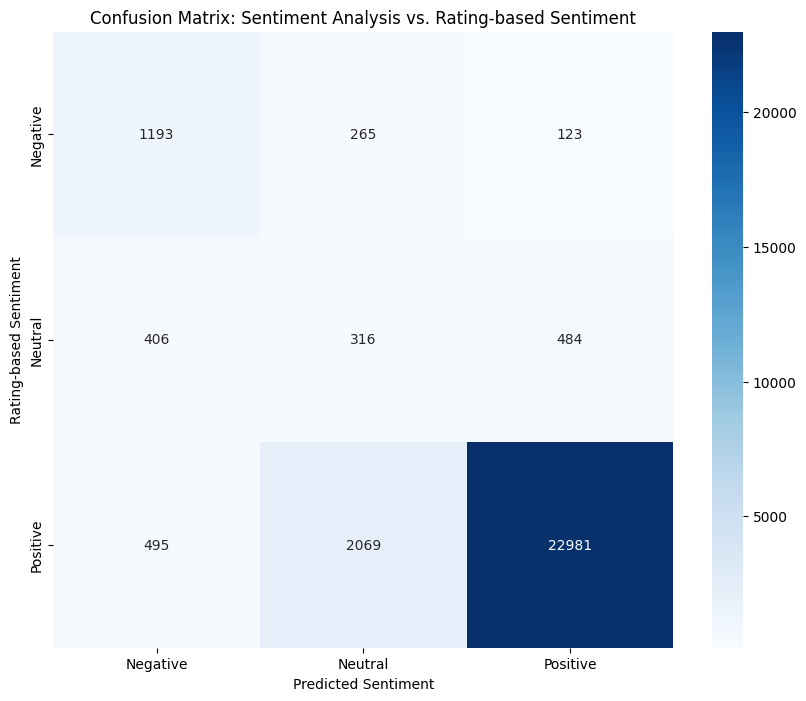

Accuracy: 0.8644

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.75      0.65      1581
     Neutral       0.12      0.26      0.16      1206
    Positive       0.97      0.90      0.94     25545

    accuracy                           0.86     28332
   macro avg       0.55      0.64      0.58     28332
weighted avg       0.92      0.86      0.89     28332

Weighted Precision: 0.9153
Weighted Recall: 0.8644
Weighted F1-score: 0.8866


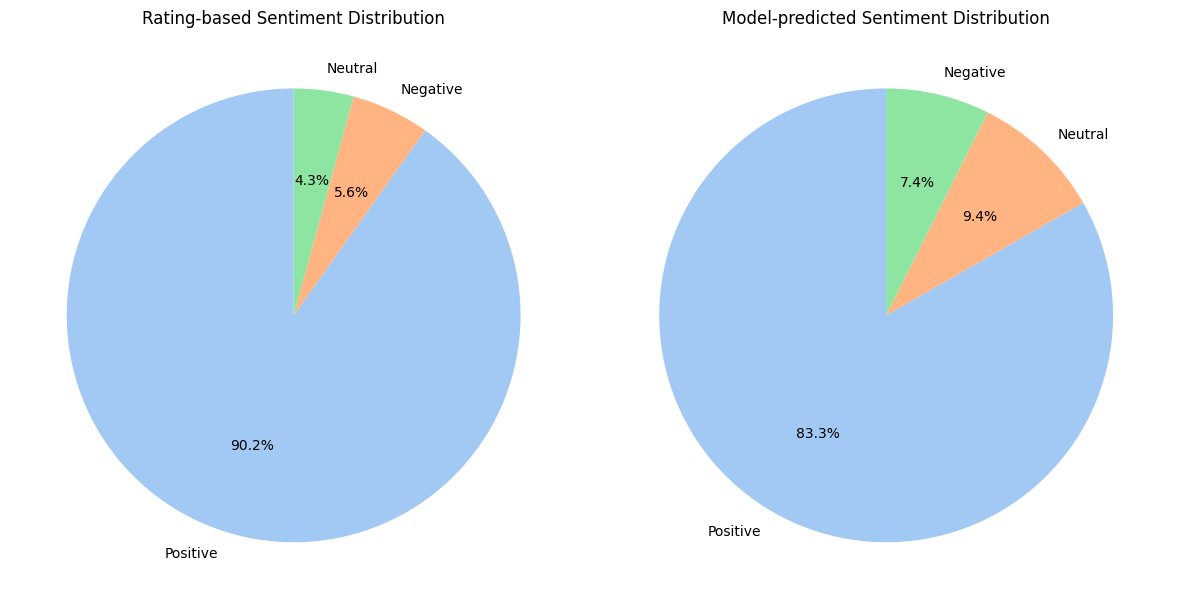

In [14]:
# Check if we have rating data to compare with
if 'rating_sentiment' in results_df.columns:
    # Map sentiment labels to the desired string format for comparison
    label_mapping = {
        'LABEL_0': 'Negative',  # Model's Negative output
        'LABEL_1': 'Neutral',   # Model's Neutral output
        'LABEL_2': 'Positive',  # Model's Positive output
        'NEUTRAL': 'Neutral'    # <--- ADDED this to preveeent the scary nan values. there are 4 reviews that are empty in the sentiment part
    }
    # Map the model's output labels to match our rating sentiment labels
    results_df['mapped_sentiment'] = results_df['sentiment_label'].map(label_mapping)

    # Create confusion matrix
    print("Confusion Matrix (Predicted vs. Rating-based):")
    conf_matrix = confusion_matrix(
        results_df['rating_sentiment'],
        results_df['mapped_sentiment'],
        labels=['Negative', 'Neutral', 'Positive']
    )

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Negative', 'Neutral', 'Positive'],
        yticklabels=['Negative', 'Neutral', 'Positive']
    )
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Rating-based Sentiment')
    plt.title('Confusion Matrix: Sentiment Analysis vs. Rating-based Sentiment')
    plt.show()

    # Calculate accuracy
    accuracy = accuracy_score(results_df['rating_sentiment'], results_df['mapped_sentiment'])
    print(f"Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    class_report = classification_report(
        results_df['rating_sentiment'],
        results_df['mapped_sentiment'],
        labels=['Negative', 'Neutral', 'Positive']
    )
    print(class_report)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(
        results_df['rating_sentiment'],
        results_df['mapped_sentiment'],
        labels=['Negative', 'Neutral', 'Positive'],
        average='weighted'
    )

    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-score: {f1:.4f}")

    # Plot sentiment distribution comparison
    plt.figure(figsize=(12, 6))

    # Plot rating-based sentiment distribution
    plt.subplot(1, 2, 1)
    rating_counts = results_df['rating_sentiment'].value_counts()
    plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Rating-based Sentiment Distribution')

    # Plot model-predicted sentiment distribution
    plt.subplot(1, 2, 2)
    sentiment_counts = results_df['mapped_sentiment'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Model-predicted Sentiment Distribution')

    plt.tight_layout()
    plt.show()

else:
    print("No rating data available for comparison. Skipping evaluation metrics.")

# NaNs
checking for NaNs

In [15]:
print("NaNs in rating_sentiment:", results_df['rating_sentiment'].isna().sum())
print("Unique values in rating_sentiment:", results_df['rating_sentiment'].unique())

print("\nNaNs in mapped_sentiment:", results_df['mapped_sentiment'].isna().sum())
print("Unique values in mapped_sentiment:", results_df['mapped_sentiment'].unique())

NaNs in rating_sentiment: 0
Unique values in rating_sentiment: ['Neutral' 'Positive' 'Negative']

NaNs in mapped_sentiment: 0
Unique values in mapped_sentiment: ['Negative' 'Neutral' 'Positive']


## Save Processed and Sentiment classyfied Data

In [16]:
# Save the processed data
processed_file_path = 'processed_sentiment_amazon_final.csv'
print(f"Saving processed data to {processed_file_path}...")
results_df.to_csv(processed_file_path, index=False)
print("Data saved successfully!")

Saving processed data to processed_sentiment_amazon_final.csv...
Data saved successfully!
